Lets use the YOLO 
Object Detection model to figure out if people are following Social Distancing amid Coronavirus

<img src="https://image.freepik.com/free-vector/social-distancing-concept_23-2148497071.jpg" width="500"/>

## Before starting the technical part of this notebook, we must seriously consider the societal consequnces of implementing this system. **Please read this carefully.**

If computer vision were to be used to identify social distancing violations, it would necessarily require surveillance of public spaces.

As we have seen around the world, public health issues, such as social distancing mandates, are handled by the government. Thus, responding to violations reported by the AI system would fall in the jurisdiction of the police. 

In America in 2020, calling the police to a non-violent situation can easily result in an innocent person being killed by police. This is especially true for black people. 

A skeptic might say that using AI to detect crime, even in the interest of public health, is giving dangerous amounts of power to police. This may remind you of [Amazon providing facial recognition tech to ICE](https://www.washingtonpost.com/business/2019/07/12/no-tech-ice-protesters-demand-amazon-cut-ties-with-federal-immigration-enforcement/) (U.S. Immigration and Customs Enforcement) that empowers them in their detaining and seperation of immigrant families. 

However, most would agree that preventing the spread of Coronavirus is a more noble cause than seperating families.
Recognizing and dispersing public gatherings quickly would help flatten the curve, likely saving lives in the long run. So we are left with a gray area, and gray areas are the hardest to judge.

How do we balance public health and privacy? When are how should we use tech as a solution? If there's one thing you should take away from this, it's that a tech solution is always a double-edged sword. Even when it looks like it's not.


## Exercise: Being a responsible technologist

If you choose to go into computer science and AI, you will make choices that impact real people. In the cell below, write a few sentences in response to each question (there are no right answers!).


In [ ]:
# 1) Do you we should think use AI to detect social distancing violations? Why or why not? 
#    No, it can be inaccurate and come with a lot of problems (such as wrongly identifying a person not social distancing.)
# 2) Say you are the leader of a team in a large tech company tasked with creating an AI social distancing detector.
#    What choices would you make while coding and designing your model to try and ensure that it does not harm others? 
#    Juts make sure it is super accurate.
# 3) After the model is coded and trained, what choices would you make while deploying the model to the real world? 
#    What situations would you want to avoid? What policies/laws could help ensure the model is used for good?   

# Building the model

In [2]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

import matplotlib.pyplot as plt
import os
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2
from copy import deepcopy
import pandas as pd


# Prepare data
DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
image_path = os.path.join(DATA_ROOT, 'image.jpg')
gdown.download(image_url, image_path, True)

image_url = 'https://drive.google.com/uc?id=1lNPGFHVkltqqlffNYPfxk1Weytr1gIgB'
img_sd1_path = os.path.join(DATA_ROOT, 'social_distance1.jpg')
gdown.download(image_url, img_sd1_path, True)

image_url = 'https://drive.google.com/uc?id=1A5ddwSZhSvyjF8JZTTG43Y8RuOB1MQo4'
img_sd2_path = os.path.join(DATA_ROOT, 'social_distance2.jpg')
gdown.download(image_url, img_sd2_path, True)

#Try changing this imagehttps://drive.google.com/open?id=1uPVeUL8ObeKjHtNdV9mUAfRG2pV00SIu
image_url = 'https://drive.google.com/uc?id=17-rsyFNkbONGE7ZLk7JIEQiflKmSEwYT'
img_sd3_path = os.path.join(DATA_ROOT, 'social_distance3.jpg')
gdown.download(image_url, img_sd3_path, True)
'''
image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
image_path = os.path.join(DATA_ROOT, 'image.jpg')
gdown.download(image_url, image_path, True)
'''

model_url = 'https://drive.google.com/uc?id=19XKJWMKDfDlag2MR8ofjwvxhtr9BxqqN'
model_path = os.path.join(DATA_ROOT, 'yolo_weights.h5')
gdown.download(model_url, model_path, True)

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]  

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image


def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w
          
          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]
              
              if((classes <= obj_thresh).all()): continue
              
              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height  
            
              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)
    
    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes
        
def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1
        
        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)    

    return new_boxes


from PIL import ImageDraw, ImageFont
import colorsys

def draw_boxes_and_get_coordinates(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
                    size=np.floor(3e-2 * image_h + 0.5).astype('int32'))
    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.
    co_ordinates_with_labels = []
    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))
        co_ordinates_with_labels.append([predicted_class, score, [(left, top), (right, bottom)]])
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image,  co_ordinates_with_labels

In [4]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Load Darknet Model (the network behind YOLO) ##

In [5]:
# Load model
darknet = tf.keras.models.load_model(model_path)

In [6]:
#@title Instructor Solution { display-mode: "form" }

### YOUR CODE HERE 
darknet = tf.keras.models.load_model(model_path)
### END CODE

## Preprocess Input Image ##

The input size of DarkNet is ```(416, 416) ```, so we need to preprocess our image into the required size by resizing our image, keeping the aspect ratio consistent. We have implemented the preprocessing for you in the ``` preprocess_input(image, net_h, net_w) ``` function, which takes the original image, the target height and width ```net_h, net_w ``` as input and returns the new image in the required size.

Also for the purpose of this notebook we have three sample images which can be accessed using ```img_sd1_path, img_sd2_path, img_sd3_path ``` respectively





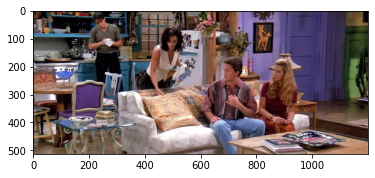

In [7]:
net_h, net_w = 416, 416

###YOUR CODE HERE ###

#Load and preprocess the image
image_pil = Image.open(img_sd1_path)
image_w, image_h = image_pil.size
new_image = preprocess_input(image_pil, net_h, net_w)

#Plot the image
plt.imshow(image_pil)
plt.show()

In [ ]:
#@title Instructor Solution { display-mode: "form" }
net_h, net_w = 416, 416
#Load and preprocess the image
image_pil = Image.open(img_sd1_path)
image_w, image_h = image_pil.size
new_image = preprocess_input(image_pil, net_h, net_w)

#Plot the image
plt.imshow(image_pil)
plt.show()

Now lets make predictions using the darknet model

In [8]:
yolo_outputs = darknet.predict(new_image)

We now have DarkNet's detection predictions for all the possible bounding boxes centered at each grid cell position, but to get the final detection results, which are the bounding boxes that the model is confident of, we need to apply a threshold to filter the results.

Furthermore, we will now call the function
```
draw_boxes_and_get_coordinates(image_pil, boxes, labels) 
```
This function returns the image with bounding boxes along with the co-ordinates with labels of all the objects



In [10]:
anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]

book 0.46 (817, 472) (970, 510)
book 0.94 (826, 456) (960, 498)
pottedplant 0.45 (683, 74) (781, 172)
chair 0.84 (84, 255) (253, 505)
chair 0.71 (1, 256) (75, 480)
person 1.00 (606, 173) (822, 505)
person 0.91 (807, 167) (968, 416)
refrigerator 0.55 (509, 75) (631, 274)
person 1.00 (398, 67) (552, 292)
person 1.00 (194, 19) (332, 277)


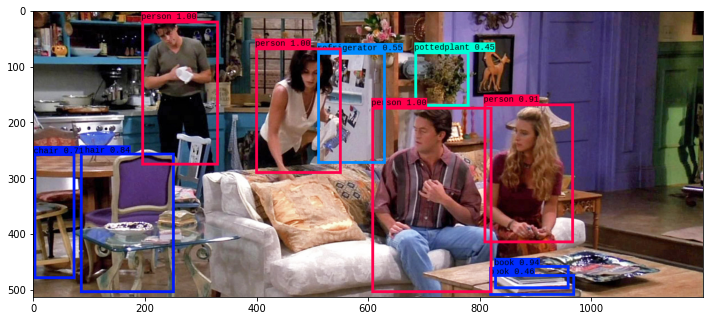

In [11]:
obj_thresh = 0.45
nms_thresh = 0.45
# Decode the output of the network

boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)

# Suppress non-maximal boxes
boxes = do_nms(boxes, nms_thresh, obj_thresh)

# Draw bounding boxes on the image using labels and get the co-ordinates
image_detect,coordinates_with_labels = draw_boxes_and_get_coordinates(image_pil, boxes, labels) 

plt.figure(figsize=(12,12))
plt.imshow(image_detect)
plt.show()

Now, since we are interested in ```person``` label category, we will write function to filter the ```person``` object co-ordinates with threshold prediction confidence



In [12]:
def filter_person_category(image_pil,coordinates_with_labels):

  image = image_pil.copy()
  person_coordinates = []
  img_draw = ImageDraw.Draw(image)

  for i in coordinates_with_labels:
    label = i[0]
    confidence = i[1]
    coordinates= i[2]
    top_left_coordinates= i[2][0]
    bottom_right_coordinates = i[2][1]
    if label =="person" and confidence > 0.90:
      
      person_coordinates.append(coordinates)
      
      img_draw.rectangle([top_left_coordinates[0], top_left_coordinates[1], 
                          bottom_right_coordinates[0], bottom_right_coordinates[1]],
                         outline='green',width=10)
      

  ###END CODE###
  del img_draw
  return image, person_coordinates


In [ ]:
#@title Instructor Solution { display-mode: "form" }
def filter_person_category(image_pil,coordinates_with_labels):

  image = image_pil.copy()
  person_coordinates = []
  
  img_draw = ImageDraw.Draw(image)
  
  for i in coordinates_with_labels:
    label = i[0]
    confidence = i[1]
    coordinates= i[2]
    top_left_coordinates= i[2][0]
    bottom_right_coordinates = i[2][1]
    if label =="person" and confidence > 0.90:
      
      person_coordinates.append(coordinates)
      
      img_draw.rectangle([top_left_coordinates[0], top_left_coordinates[1], 
                          bottom_right_coordinates[0], bottom_right_coordinates[1]],
                         outline='green',width=10)
      
      
  del img_draw
  return image, person_coordinates


In [13]:
image_person, person_coordinates = filter_person_category(image_pil,coordinates_with_labels)

Lets view the image with only person category marked!

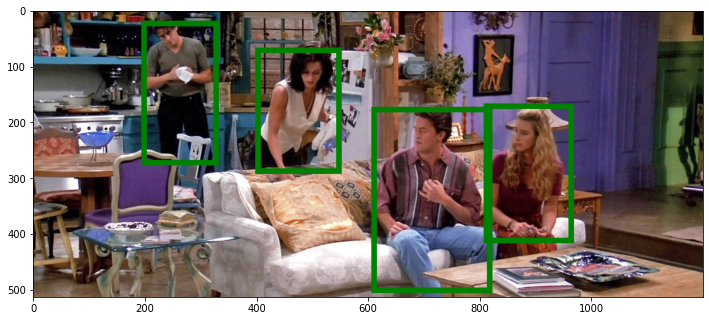

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(image_person)
plt.show()

## Compute Midpoints ##

Our final goal is to compute the distance between different people and classify if they are socially distant or not. For this purpose, we will compute the distance between the midpoint of the bounding boxes. To keep it simple, we will use the bottom centre midpoint to compute this distance.

In [15]:
'''
Compute bottom centre midpoint of each bounding box
'''
def get_midpoints(image,person_coordinates):

  midpoints = []
  for i,coordinates in enumerate(person_coordinates):
    
    (x1,y1),(x2,y2) = coordinates
    #compute bottom center of bbox
    x_mid = int((x1+x2)/2)
    y_mid = int(y2)
    mid   = (x_mid,y_mid)
    midpoints.append(mid)
  return midpoints

In [ ]:
#@title Instructor Solution { display-mode: "form" }
def get_midpoints(image,person_coordinates):

  midpoints = []
  for i,coordinates in enumerate(person_coordinates):
    
    (x1,y1),(x2,y2) = coordinates
    #compute bottom center of bbox
    x_mid = int((x1+x2)/2)
    y_mid = int(y2)
    mid   = (x_mid,y_mid)
    midpoints.append(mid)
  return midpoints

In [38]:
midpoints = get_midpoints(image_pil,person_coordinates)

## Compute Euclidean Distance ##

We will now compute the euclidean distance using the midpoints for each person with all other people in the frame.

Make sure your code deals with the scenario where you dont compute the same distance twice! 

For ex : Distance between ```person 1``` and ```person 2``` is same as that of ```person 2``` and ```person 1``` 


To compute the euclidean distance, we will use ```distance.euclidean(arg1, arg2) ```
from the ```scipy``` library





In [39]:
from scipy.spatial import distance

def compute_distance(midpoints,num):
  # Create n * n matrix to store the distance
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  ### END CODE ###

In [40]:
#@title Instructor Solution { display-mode: "form" }
from scipy.spatial import distance

def compute_distance(midpoints,num):
  # Create n * n matrix to store the distance
  dist = np.zeros((num,num))
  ### YOUR CODE HERE ###
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  ### END CODE ###
  return dist

In [41]:
num_people =  len(midpoints)
dist= compute_distance(midpoints,num_people)

## Lets find folks who are not socially distant !!! ###

Now that we have all the distance computed, we need to define distance threshold as to how apart people should be from each other!



```distance threshold ``` is a hyper-parameter here and can differ across images with different aspect ratios since we dont take camera calibration into account in this notebook

Note : Do not compute the distance of person with himself



In [42]:
'''
Returns the distance , pairs id with distance less than threshold 
'''
def filter_pairs_less_distance(dist,num):

  distance =[]
  person1=[]
  person2=[]
  threshold = 350
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=threshold)):
        person1.append(i)
        person2.append(j)
        distance.append(dist[i][j])
  return person1, person2, distance

In [33]:
#@title Instructor Solution { display-mode: "form" }
'''
Returns the distance , pairs id with distance less than threshold 
'''
def filter_pairs_less_distance(dist,num):

  distance =[]
  person1=[]
  person2=[]
  threshold = 350
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=threshold)):
        person1.append(i)
        person2.append(j)
        distance.append(dist[i][j])
  return person1, person2, distance

In [43]:
person1, person2, distance = filter_pairs_less_distance(dist,num_people)

In [44]:
df = pd.DataFrame({"person1":person1,"person2":person2,"distance":distance})

The unique set of the person specified in list person1 and person2 are the folks who are not socially distant! However, if these lists are empty that means all the folks are socially distant in the given image frame

However, lets see if thats right. Lets fetch the bounding box co-ordinates for these people are plot them in red!




In [45]:
if len(df) == 0:
  print ("People are Socially distant")
else:
  print ("People with Red Box are not following socially distant rules")

People with Red Box are not following socially distant rules


In [46]:
def plot_red_bbox(img,co_ordinates,person1,person2):
  img_draw = ImageDraw.Draw(img)
  no_social_distance = np.unique(person1 + person2)
  
  for i in no_social_distance:
    (x1,y1) = co_ordinates[i][0]
    (x2,y2) = co_ordinates[i][1]
    img_draw.rectangle([x1,y1,x2,y2],outline='red',width=10)
  del img_draw
  return img

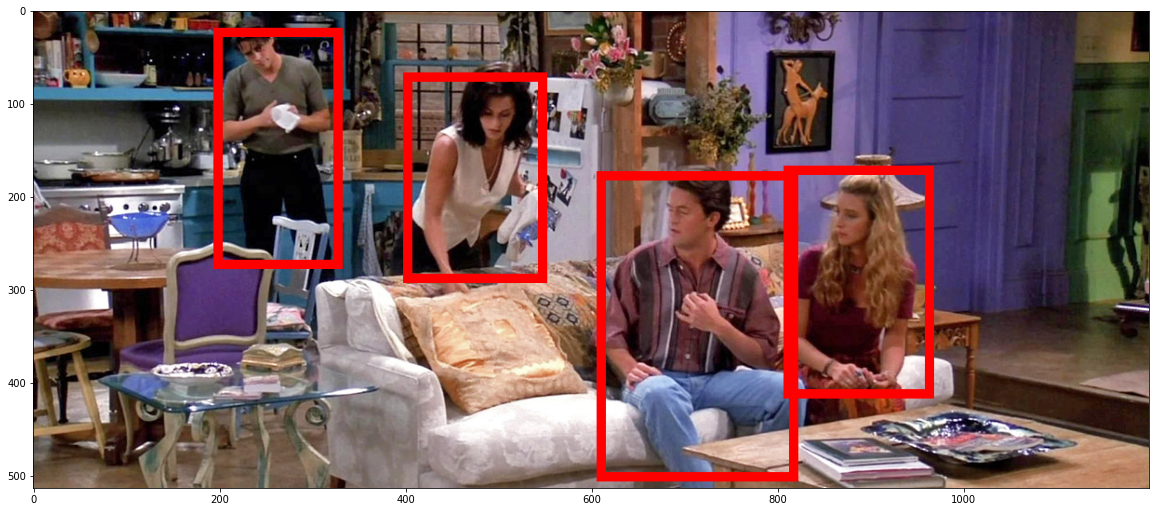

In [47]:
img = plot_red_bbox(image_person,person_coordinates,person1,person2)

plt.figure(figsize=(20,10))
plt.imshow(img)